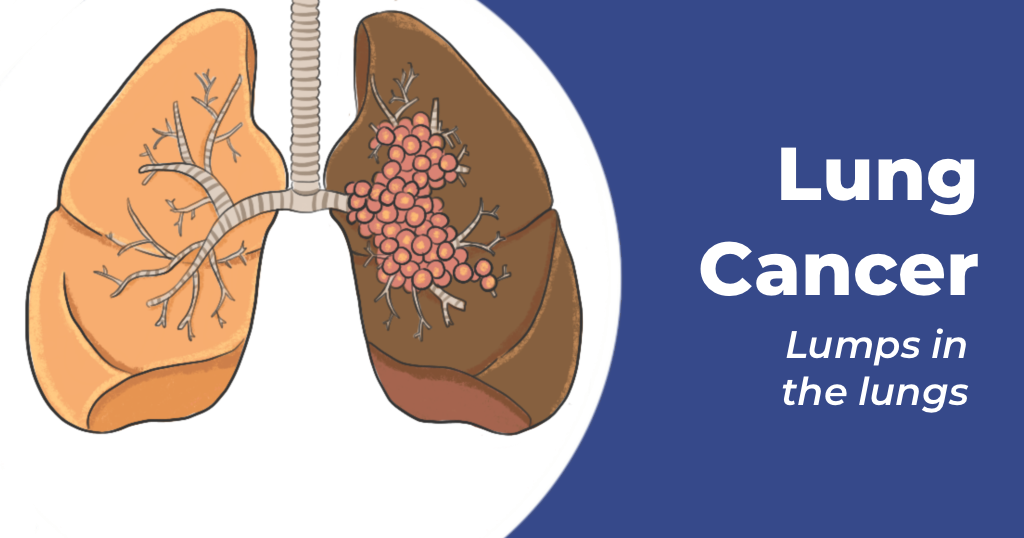

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## About the data

folder lung_image_sets contains three secondary subfolders: lung_aca subfolder with 5000 images of lung adenocarcinomas, lung_scc subfolder with 5000 images of lung squamous cell carcinomas, and lung_n subfolder with 5000 images of benign lung tissues.

# Importing libraries

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Data loading and exploring

In [ ]:
lung_dir = "/content/drive/MyDrive/Research/Lung Cancer Dataset"
lungs = os.listdir(lung_dir)

In [ ]:
lungs

['lung_scc', 'lung_aca', 'lung_n']

In [ ]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for lung in lungs:
    nums_train[lung] = len(os.listdir(lung_dir + '/' + lung))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
Lung_Squamous_Cell_Carcinoma,5000
Lung_Adenocarcinoma,5000
Lung-Benign_Tissue,3766


<Axes: title={'center': 'data distribution '}, xlabel='Type of lung cancer', ylabel='Number of image'>

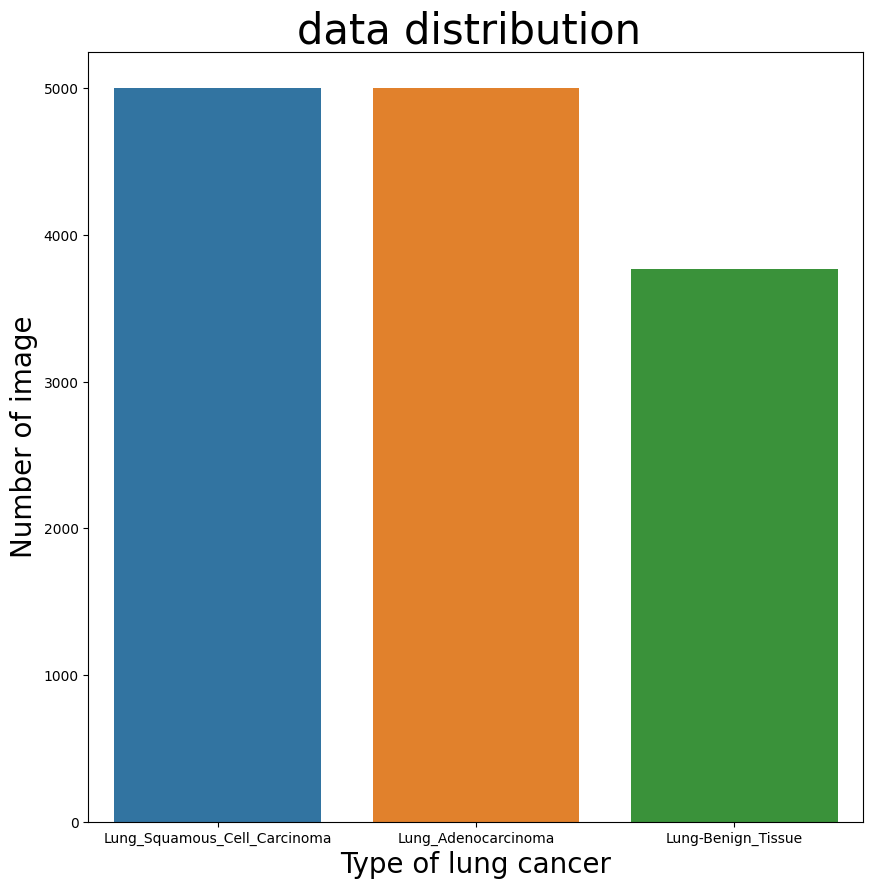

In [ ]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of lung cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)


# Show some example for lung cancer

In [ ]:
# Function to show image
train = ImageFolder(lung_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

## Lung_aca

Label :Lung-Benign_Tissue(0)


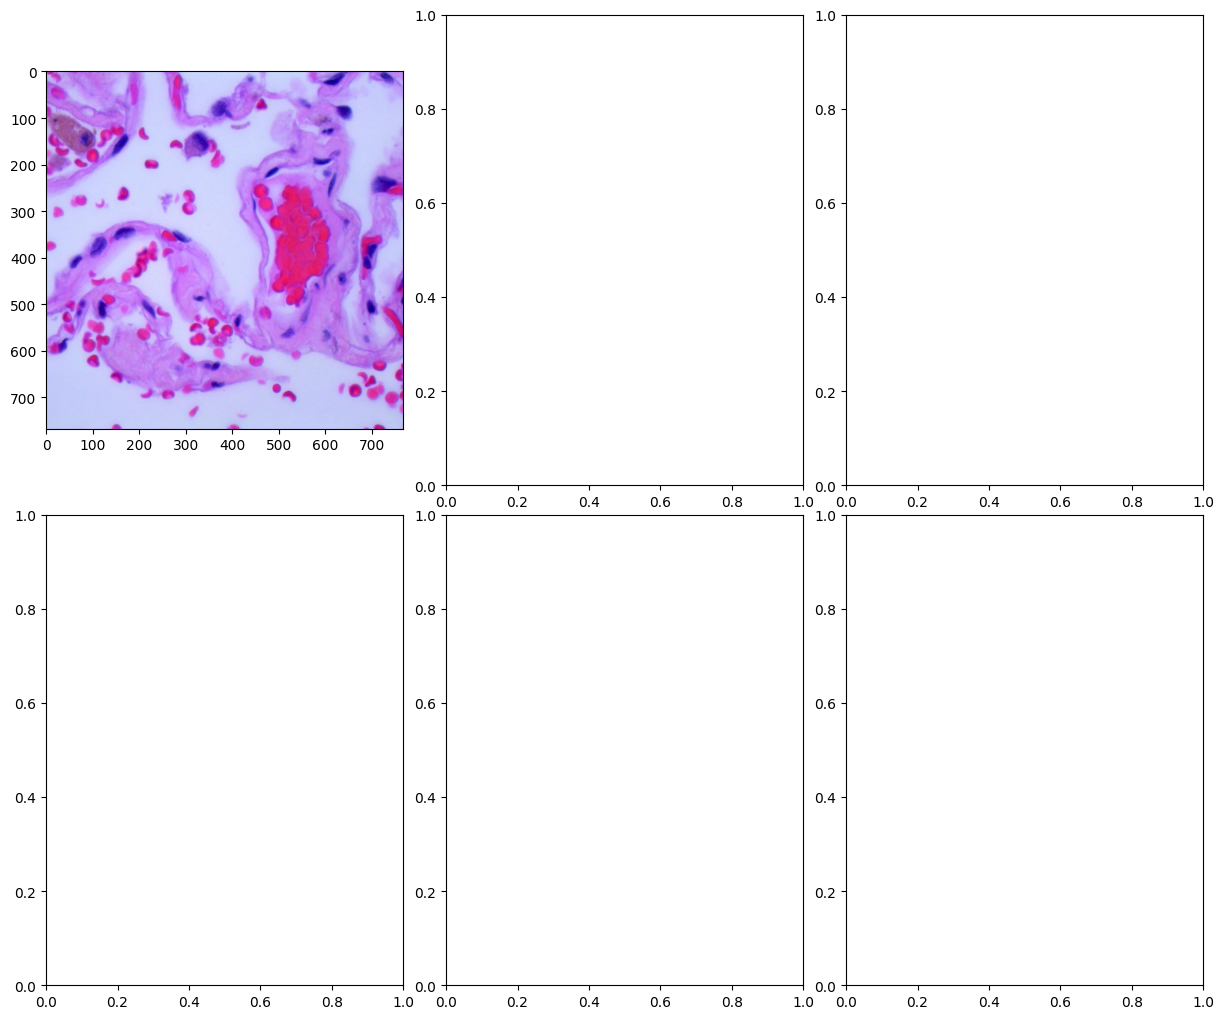

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[500]))


In [ ]:
axs[0,0].imshow(show_image(*train[1]))

Label :Lung-Benign_Tissue(0)


## Lung_n

Label :lung_aca(0)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)


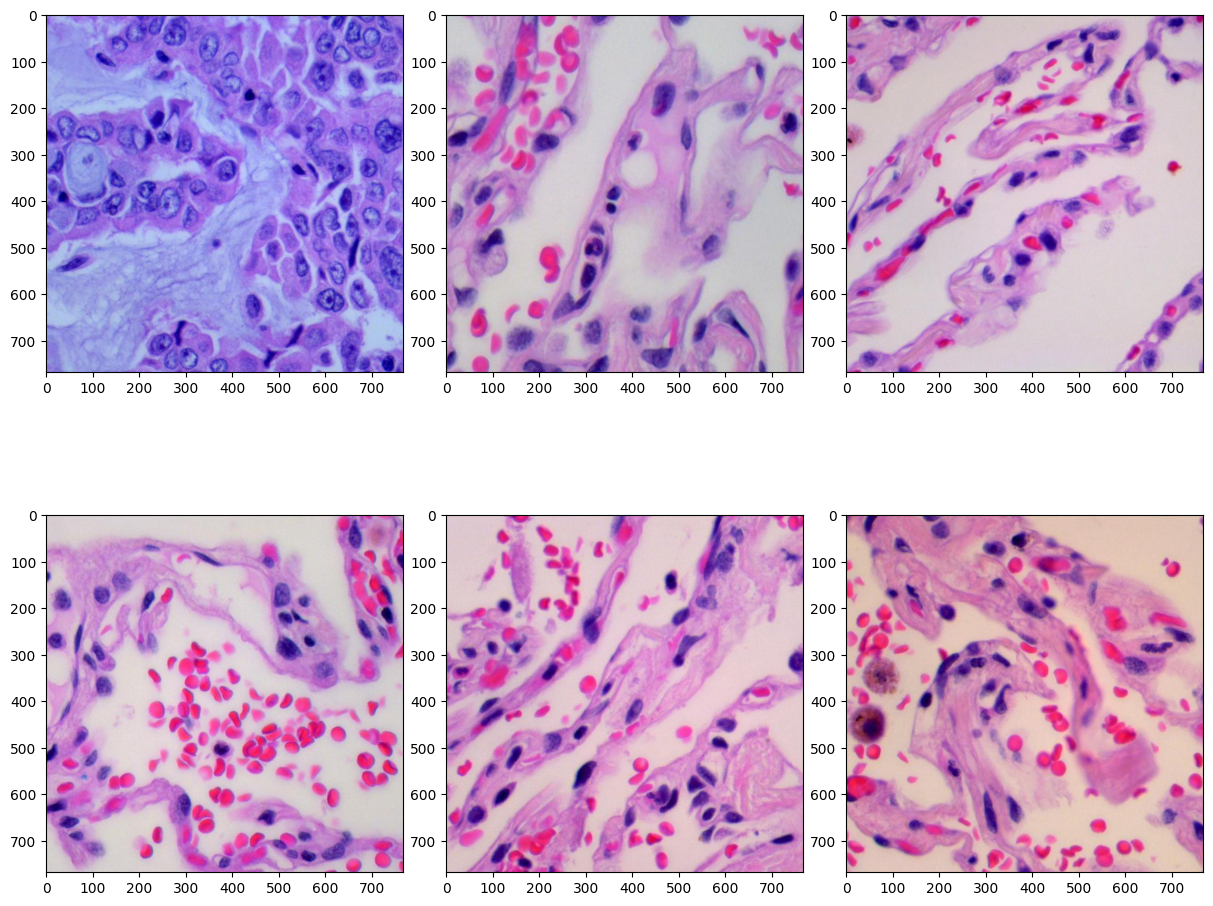

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5010]))
axs[0,1].imshow(show_image(*train[6050]))
axs[1, 0].imshow(show_image(*train[7000]))
axs[1,1].imshow(show_image(*train[7500]))
axs[0,2].imshow(show_image(*train[8000]))
axs[1,2].imshow(show_image(*train[8620]))

## Lung_scc

Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)


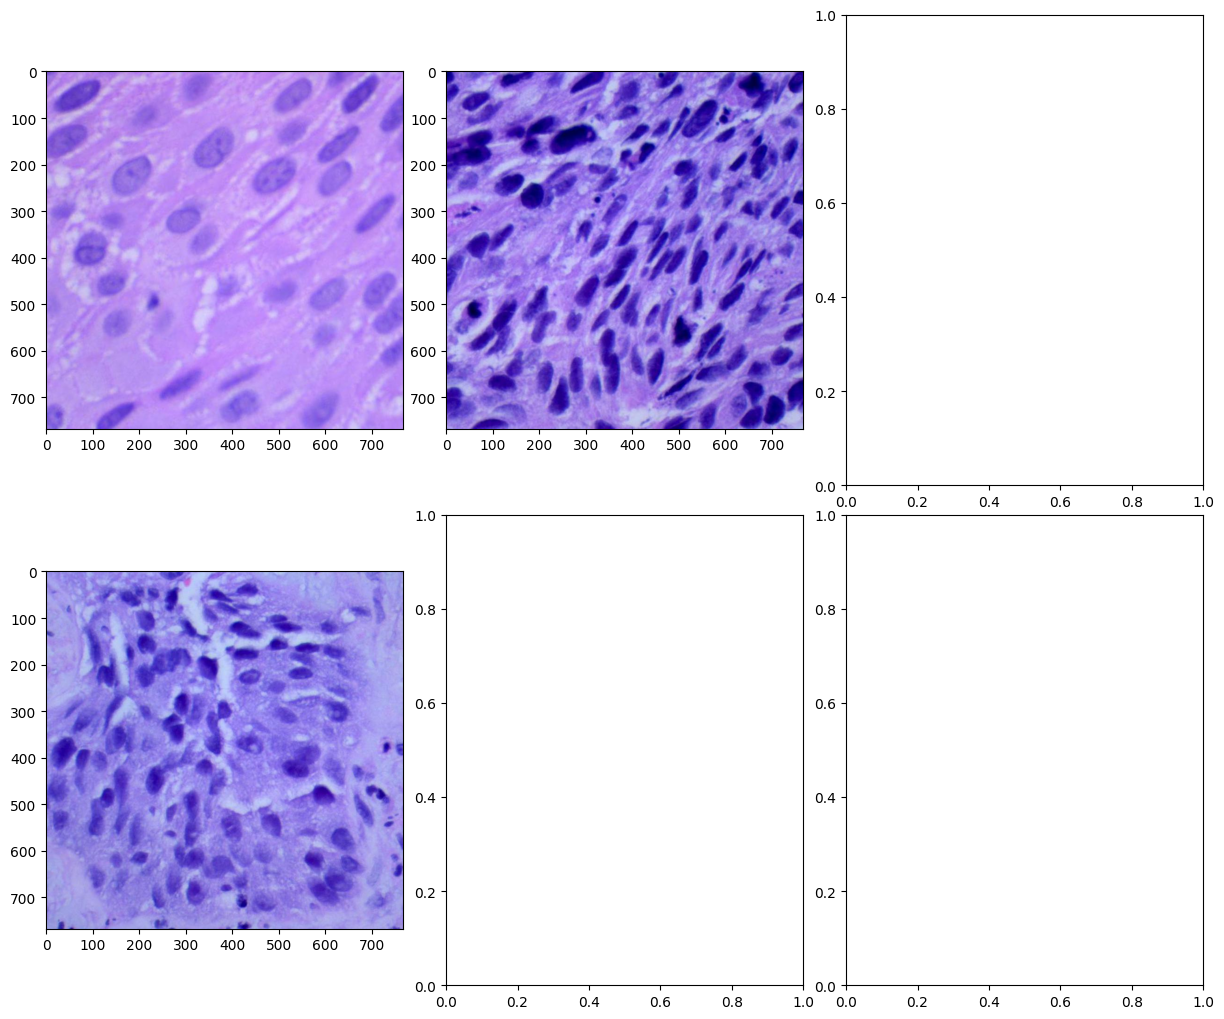

In [ ]:
 fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[11001]))
axs[0,1].imshow(show_image(*train[12000]))
axs[1, 0].imshow(show_image(*train[13050]))

# Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(lung_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(lung_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)

Found 12032 images belonging to 3 classes.
Found 3008 images belonging to 3 classes.


In [ ]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 1006, 1: 1002, 2: 1000}

## model_1

In [ ]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.15))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(128, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(3, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

In [ ]:
keras.utils.plot_model(
    model_1,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=50,
    layer_range=None,
    show_layer_activations=False,
)

NameError: ignored

In [ ]:
history = model_1.fit(train_data,
          validation_data=val_data,
          epochs = 10)

Epoch 1/10
188/188 [==============================] - 3965s 21s/step - loss: 0.7728 - accuracy: 0.7503 - val_loss: 0.4113 - val_accuracy: 0.8730
Epoch 2/10
150/188 [======================>.......] - ETA: 5:49 - loss: 0.3255 - accuracy: 0.8675

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_1.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

## Model_2

In [ ]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_2.add(keras.layers.Dropout(0.1))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(3, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

In [ ]:
keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_2.fit(train_data,
          validation_data=val_data,
          epochs = 10)

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_2.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

## Model_3

In [ ]:
model_3 = keras.models.Sequential()

model_3.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(128, activation='relu'))
model_3.add(keras.layers.Dense(3, activation='softmax'))

model_3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

In [ ]:
keras.utils.plot_model(
    model_3,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_3.fit(train_data,
          validation_data=val_data,
          epochs = 15)

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_3.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Testing with custom input

In [ ]:
def classify_lung_cancer(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0


    predictions = model_1.predict(np.expand_dims(img, axis=0))

    predicted_class_index = np.argmax(predictions)
    class_names = ["Lung ACA", "Lung N", "Lung SCC"]

    predicted_class = class_names[predicted_class_index]
    return predicted_class

input_image_path = "test.jpg"

predicted_class = classify_lung_cancer(input_image_path)

print(f"The input image is classified as: {predicted_class}")